In [1]:
library(dplyr)
library(stringr)
library(Seurat) # Seurat v4.1.0
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(reshape2)
library(ggbeeswarm)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite



In [8]:
#directory_path = '.'
folder_list = list.dirs(full.names = FALSE, recursive = FALSE)
folder_list=folder_list[startsWith(folder_list,'2')]
names(folder_list) = paste0('P',seq(1,length(folder_list)))
folder_list

P1                    P2                    P3 
"241118Lov_D24-17752" "241118Lov_D24-17753" "241118Lov_D24-17754" 
                   P4                    P5                    P6 
"241118Lov_D24-17755" "241118Lov_D24-17756" "241118Lov_D24-17757" 
                   P7                    P8 
"241118Lov_D24-17758" "241118Lov_D24-17759"

In [5]:
system('gzip */Solo.out/GeneFull/filtered/*.mtx')


In [6]:
system('gzip */Solo.out/GeneFull/filtered/*.tsv')


In [10]:
for (folder in folder_list){
    file_path = paste0(folder, '/Solo.out/GeneFull/filtered/')
    mtx = Read10X(file_path)
    
    sample = names(folder_list[folder_list == folder])
    print(sample)
    seurat_obj = CreateSeuratObject(counts = mtx, project=sample, min.cells = 3, min.features = 100)
    if (folder == folder_list[1]) {
        srat1 = seurat_obj
    } else if (folder == folder_list[2]){
        srat.rest = seurat_obj
    } else {
        srat.rest=c(srat.rest,seurat_obj)
    }
}
seurat_obj = merge(srat1,srat.rest,add.cell.ids = names(folder_list))

[1] "P1"
[1] "P2"
[1] "P3"
[1] "P4"
[1] "P5"
[1] "P6"
[1] "P7"
[1] "P8"


In [11]:
seurat_obj

An object of class Seurat 
25707 features across 44861 samples within 1 assay 
Active assay: RNA (25707 features, 0 variable features)
 8 layers present: counts.P1, counts.P2, counts.P3, counts.P4, counts.P5, counts.P6, counts.P7, counts.P8

In [13]:
saveRDS(seurat_obj,'00_241118Lov_initial_seurat.RDS')

In [ ]:
#### cell hashing ####

In [2]:
srat.orig = readRDS('00_241118Lov_initial_seurat.RDS')
srat.orig$cell_id = rownames(srat.orig@meta.data)
head(srat.orig@meta.data)
srat.orig

,orig.ident,nCount_RNA,nFeature_RNA,cell_id
,<chr>,<dbl>,<int>,<chr>
P1_AAAAAAAACCCA,P1,669,271,P1_AAAAAAAACCCA
P1_AAAAAATGTCAA,P1,957,382,P1_AAAAAATGTCAA
P1_AAAAACCTATTT,P1,1259,429,P1_AAAAACCTATTT
P1_AAAAACCTGGCT,P1,583,379,P1_AAAAACCTGGCT
P1_AAAAAGAAGTCA,P1,1712,737,P1_AAAAAGAAGTCA
P1_AAAAATCCGTAA,P1,2629,1154,P1_AAAAATCCGTAA


An object of class Seurat 
25707 features across 44861 samples within 1 assay 
Active assay: RNA (25707 features, 0 variable features)
 8 layers present: counts.P1, counts.P2, counts.P3, counts.P4, counts.P5, counts.P6, counts.P7, counts.P8

In [3]:
hto.mtx = read.csv('../citeseq_results_dense.csv', row.names=1, sep = ',')
hto.mtx$orig = sapply(str_split(rownames(hto.mtx),'_'), "[[", 1)


In [4]:
# find intersection 
cells.use = intersect(rownames(hto.mtx), srat.orig$cell_id)
length(cells.use)

# only keep the hashtags that have a match in seurat object 
hto.mtx = hto.mtx[cells.use,]
dim(hto.mtx)

# only keep the cells that have a match in hashtag dataframe
srat = subset(srat.orig, subset = cell_id %in% cells.use)
dim(srat)

# match the cell names between seurat and hashtag count matrices 
bcs_to_names = colnames(srat)
names(bcs_to_names) = srat@meta.data$cell_id
rownames(hto.mtx) = bcs_to_names[rownames(hto.mtx)]
hto.mtx[is.na(hto.mtx)] = 0

[1] 26972

[1] 26972    19

[1] 25707 26972

In [5]:
colSums(hto.mtx[1:17])

HTO1.ACCCACCAGTAAGAC  HTO2.GGTCGAGAGCATTCA  HTO3.CTTGCCGCATGTCAT 
              1091939               1151802                   852 
 HTO4.AAAGCATTCTTCACG  HTO5.CTTTGTCTTTGTGAG  HTO6.TATGCTGCCACGGTA 
               792389                664119                    18 
 HTO7.GAGTCTGCCAGTATC  HTO8.TATAGAACGCCAGGC  HTO9.TGCCTATGAAACAAG 
              1242886                     0                    61 
HTO10.CCGATTGTAACAGAC HTO11.GCTTACCGAATTAAC HTO12.CTGCAAATATAACGG 
                  736                     0                     1 
HTO13.CTACATTGCGATTTG HTO14.CTTTCGCCAACTCTG HTO15.CCCTCTCTGGATTCT 
                    0                   105                     0 
HTO19.GAATTAGCTGTGCAA HTO20.CAAGTATCTGCCGTG 
                    0                     0

In [7]:
# Create HTO assay 
hto.mtx = hto.mtx[,c(1,2,4,5,7)]
srat[['HTO']]=CreateAssayObject(counts =t(hto.mtx))

In [8]:
# Normalize HTO data
srat = NormalizeData(srat, assay = "HTO", normalization.method = "CLR")
srat = HTODemux(srat, assay = "HTO", positive.quantile = 0.99, verbose=FALSE)

Normalizing across features

As of Seurat v5, we recommend using AggregateExpression to perform pseudo-bulk analysis.
This message is displayed once per session.
First group.by variable `ident` starts with a number, appending `g` to ensure valid variable names
This message is displayed once every 8 hours.


In [9]:
table(srat$HTO_classification.global)


 Doublet Negative  Singlet 
   14407     6064     6501 

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


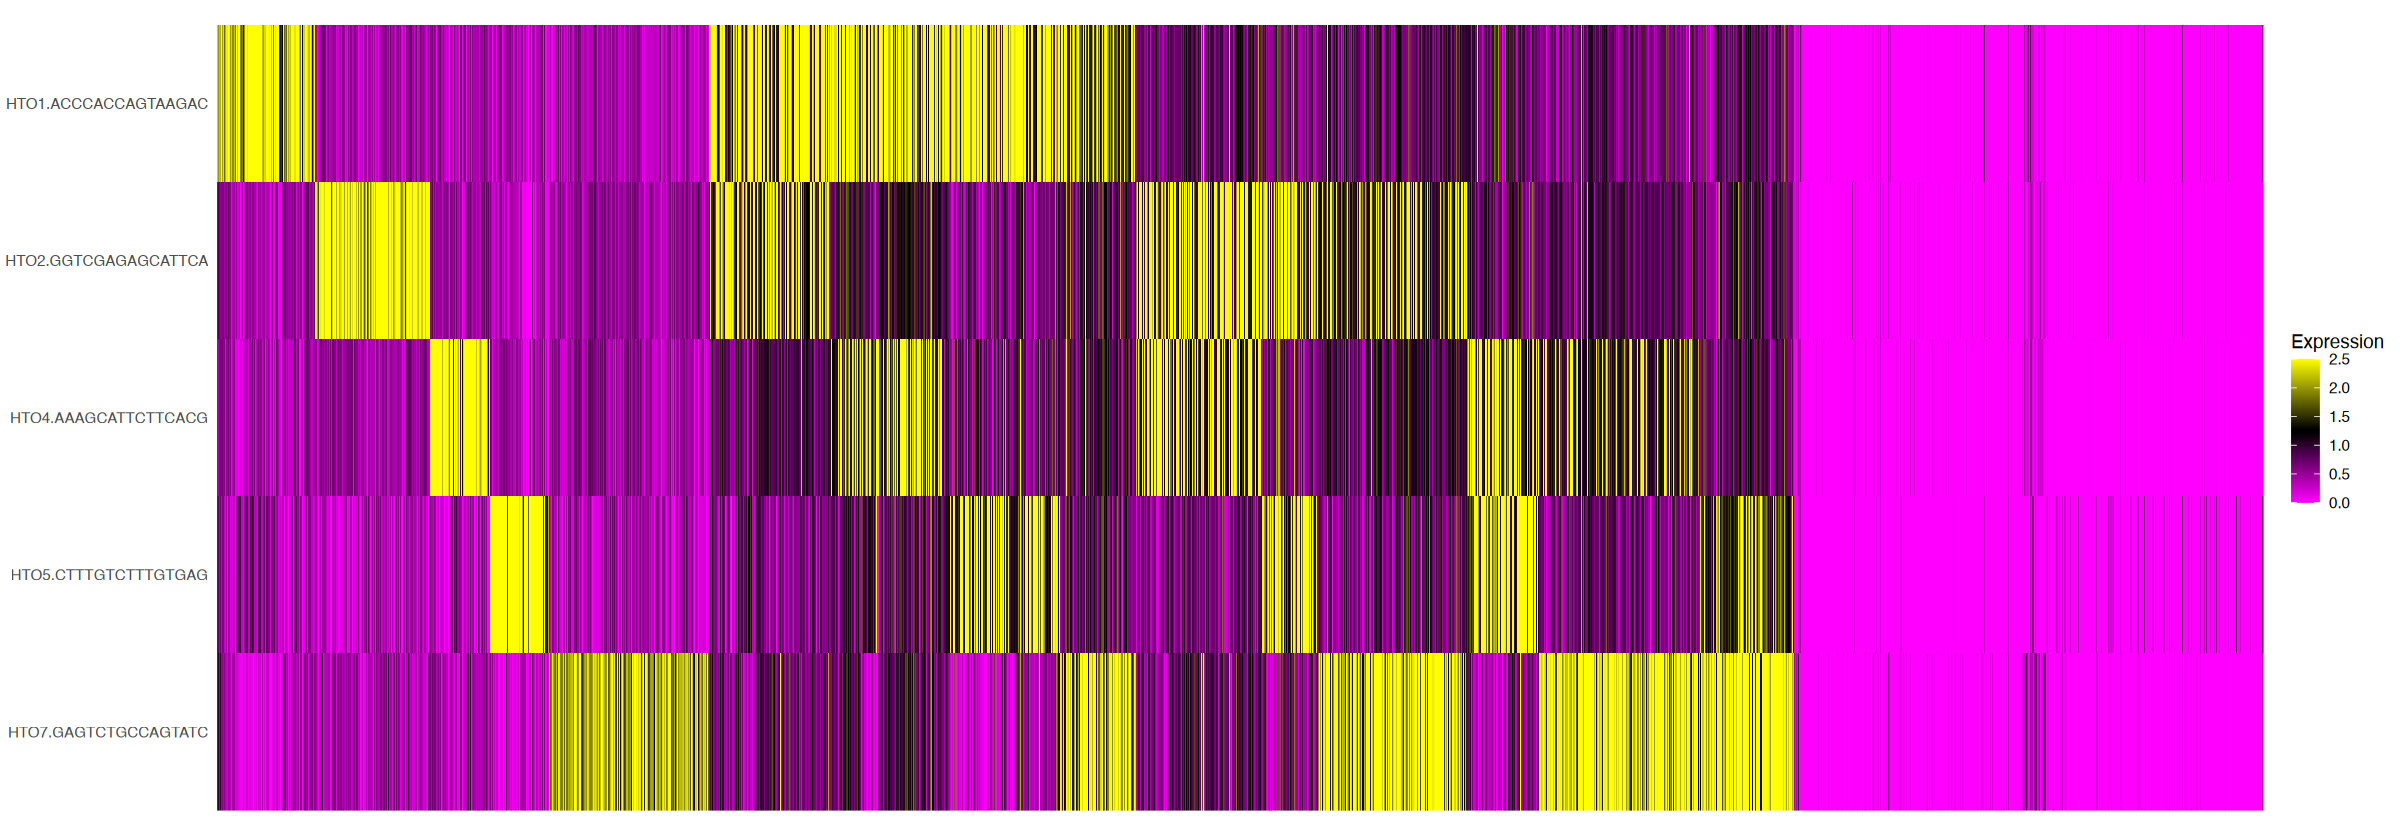

In [10]:
options(repr.plot.width=20)
HTOHeatmap(srat, assay = "HTO")

In [11]:
table(srat$hash.ID,srat$orig.ident)

                      
                         P1   P2   P3   P4   P5   P6   P7   P8
  Doublet              2866 2314   30 1047 3987 1533 2610   20
  HTO7.GAGTCTGCCAGTATC  774   31    6  123  583   56  515    4
  HTO2.GGTCGAGAGCATTCA  686   58   12  162  317   14  290    2
  HTO5.CTTTGTCTTTGTGAG   32  348    2    7   34  348   24   75
  HTO4.AAAGCATTCTTCACG  234   86    8   59  187    7  146    2
  HTO1.ACCCACCAGTAAGAC  254  593    6   53  147   53  161    2
  Negative               64   17 3051   68   62   32  130 2640

In [12]:
saveRDS(srat, '01_241118Lov_HTO_siglet.RDS')

In [9]:
table(seurat_obj$orig.ident)


  P1   P2   P3   P4   P5   P6   P7   P8 
7362 5518 5938 3018 7846 3519 6601 5059 

In [10]:
seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^mt-")


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


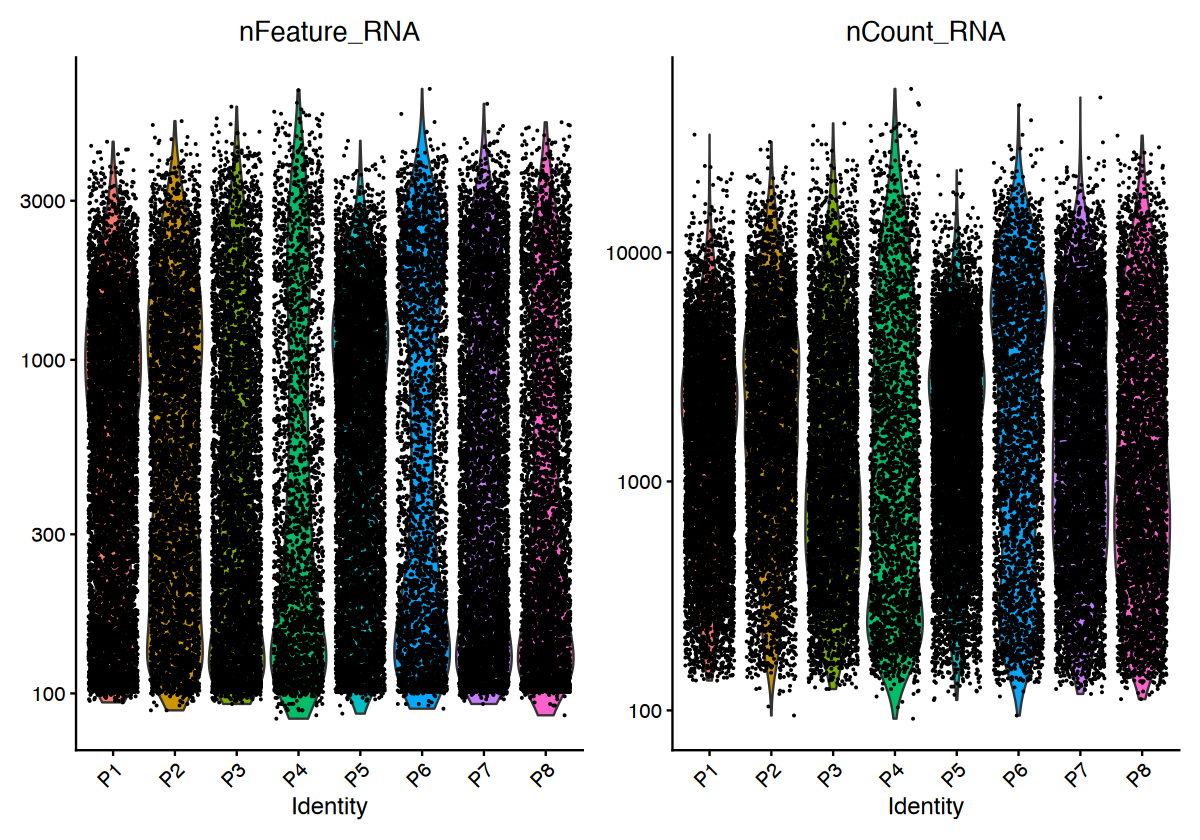

In [11]:
options(repr.plot.width=10)
VlnPlot(seurat_obj, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2,log = TRUE) 

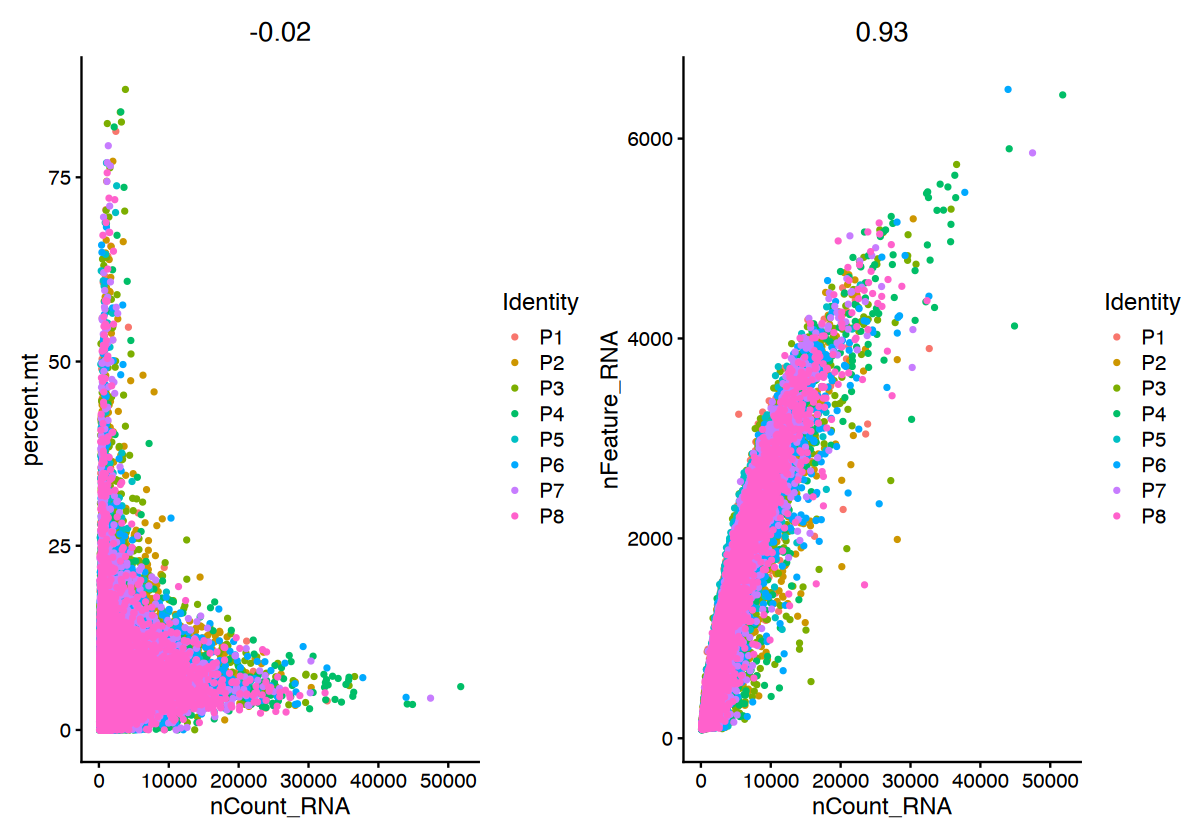

In [12]:
plot1 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [13]:
srat= subset(seurat_obj, subset = nFeature_RNA>300 & percent.mt<25) 
table(srat$orig.ident)
srat


  P1   P2   P3   P4   P5   P6   P7   P8 
4910 3447 3115 1519 5317 2043 3876 2745 

An object of class Seurat 
25707 features across 26972 samples within 1 assay 
Active assay: RNA (25707 features, 0 variable features)
 8 layers present: counts.P1, counts.P2, counts.P3, counts.P4, counts.P5, counts.P6, counts.P7, counts.P8

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


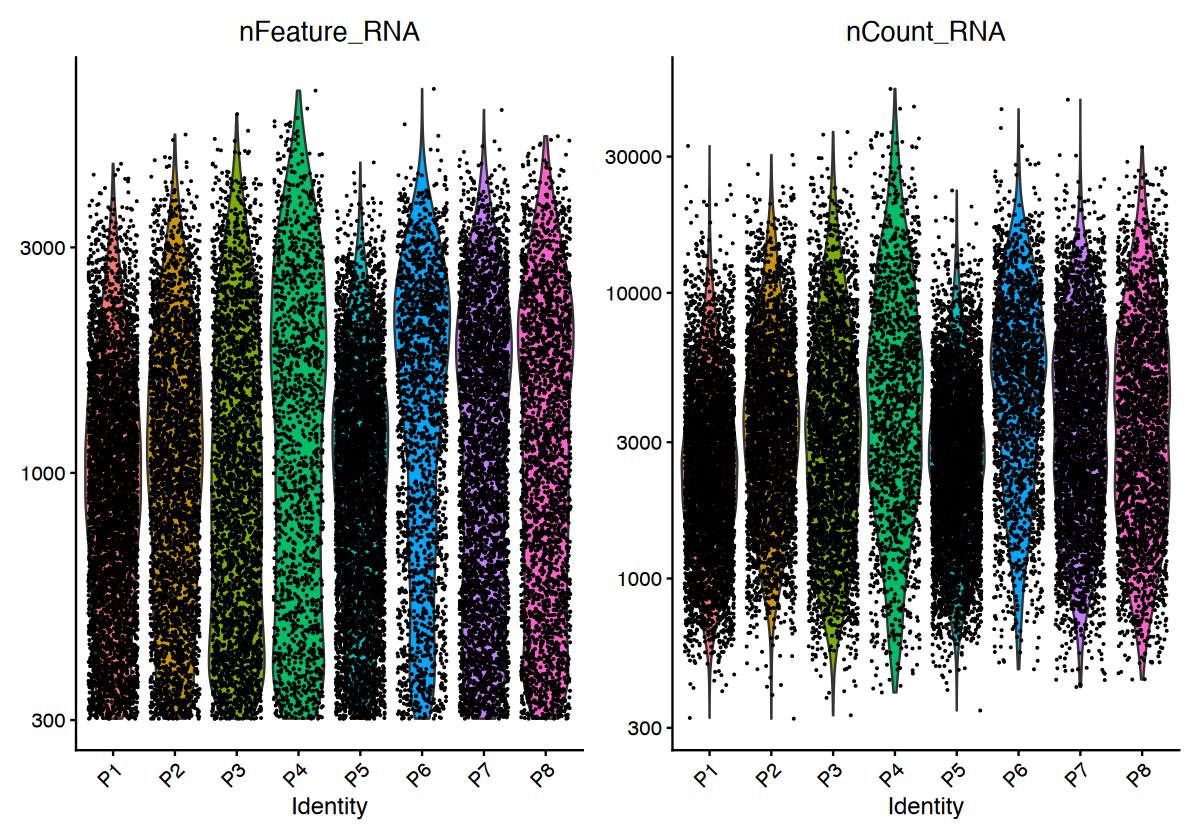

In [14]:
options(repr.plot.width=10)
VlnPlot(srat, features = c("nFeature_RNA", "nCount_RNA"), ncol = 2,log = TRUE) 

In [15]:
srat <- NormalizeData(srat, verbose=FALSE)
srat <- FindVariableFeatures(srat, selection.method = "vst", nfeatures = 2000, verbose=FALSE)
srat <- ScaleData(srat, vars.to.regress = c('nFeature_RNA',"percent.mt"), verbose=FALSE)
srat <- RunPCA(srat, verbose=FALSE)



Normalizing layer: counts.P1

Normalizing layer: counts.P2

Normalizing layer: counts.P3

Normalizing layer: counts.P4

Normalizing layer: counts.P5

Normalizing layer: counts.P6

Normalizing layer: counts.P7

Normalizing layer: counts.P8

Finding variable features for layer counts.P1

Finding variable features for layer counts.P2

Finding variable features for layer counts.P3

Finding variable features for layer counts.P4

Finding variable features for layer counts.P5

Finding variable features for layer counts.P6

Finding variable features for layer counts.P7

Finding variable features for layer counts.P8

Regressing out nFeature_RNA, percent.mt

Centering and scaling data matrix

PC_ 1 
Positive:  Top2a, Mki67, Pclaf, Hmgb2, Tubb5, Rrm2, Rrm1, H2az1, Stmn1, Kif11 
	   Ccna2, Uhrf1, Lmnb1, Ptma, Kif15, Lig1, Tpx2, Ncapd2, Mcm5, Tuba1b 
	   H1f5, Incenp, Clspn, Pcna, Ncapg2, Cdca8, Nusap1, Spc24, Smc2, H1f3 
Negative:  Skap1, Tcf7, Gm2682, Ms4a4b, Prkcq, Sell, Trbc2, Fyb1, Itk, Utrn 


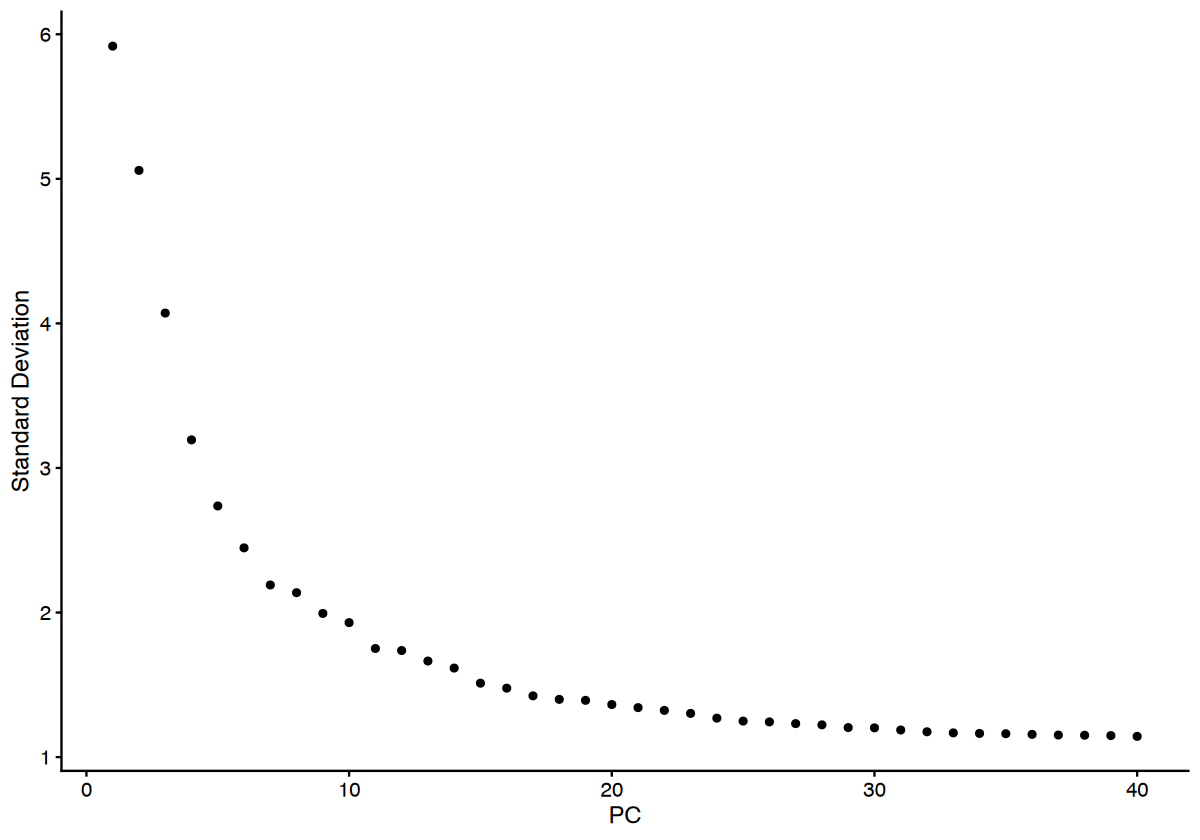

In [17]:
ElbowPlot(srat, 40)


In [18]:
srat <- FindNeighbors(srat, dims = 1:20, verbose=FALSE)
srat <- RunUMAP(srat, dims = 1:20, verbose=FALSE)
srat <- FindClusters(srat, resolution = c(0.1,0.3,0.5), verbose=FALSE)


Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:52:20 UMAP embedding parameters a = 0.9922 b = 1.112

15:52:20 Read 26972 rows and found 20 numeric columns

15:52:20 Using Annoy for neighbor search, n_neighbors = 30

15:52:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:52:22 Writing NN index file to temp file /var/folders/7m/sjcgg3f54m3_11pn4yqny6l40000gn/T//Rtmp2kOI5v/file162f020cea3e6

15:52:22 Searching Annoy index using 1 thread, search_k = 3000

15:52:30 Annoy recall = 100

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26972
Number of edges: 816407

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9343
Number of communities: 4
Elapsed time: 6 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26972
Number of edges: 816407

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8839
Number of communities: 11
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 26972
Number of edges: 816407

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8568
Number of communities: 13
Elapsed time: 5 seconds


In [19]:
colnames(srat@meta.data)

[1] "orig.ident"      "nCount_RNA"      "nFeature_RNA"    "percent.mt"     
[5] "RNA_snn_res.0.1" "RNA_snn_res.0.3" "RNA_snn_res.0.5" "seurat_clusters"

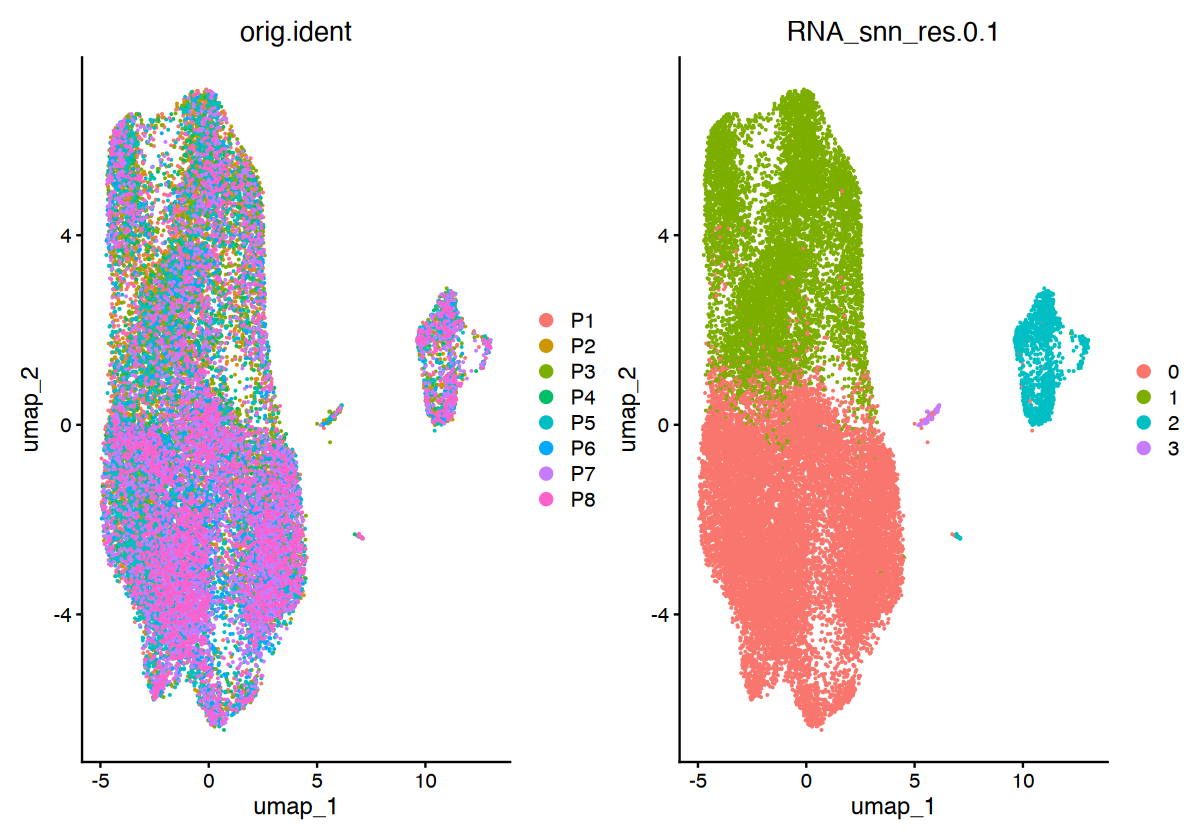

In [24]:
DimPlot(srat, group.by=c('orig.ident','RNA_snn_res.0.1'))

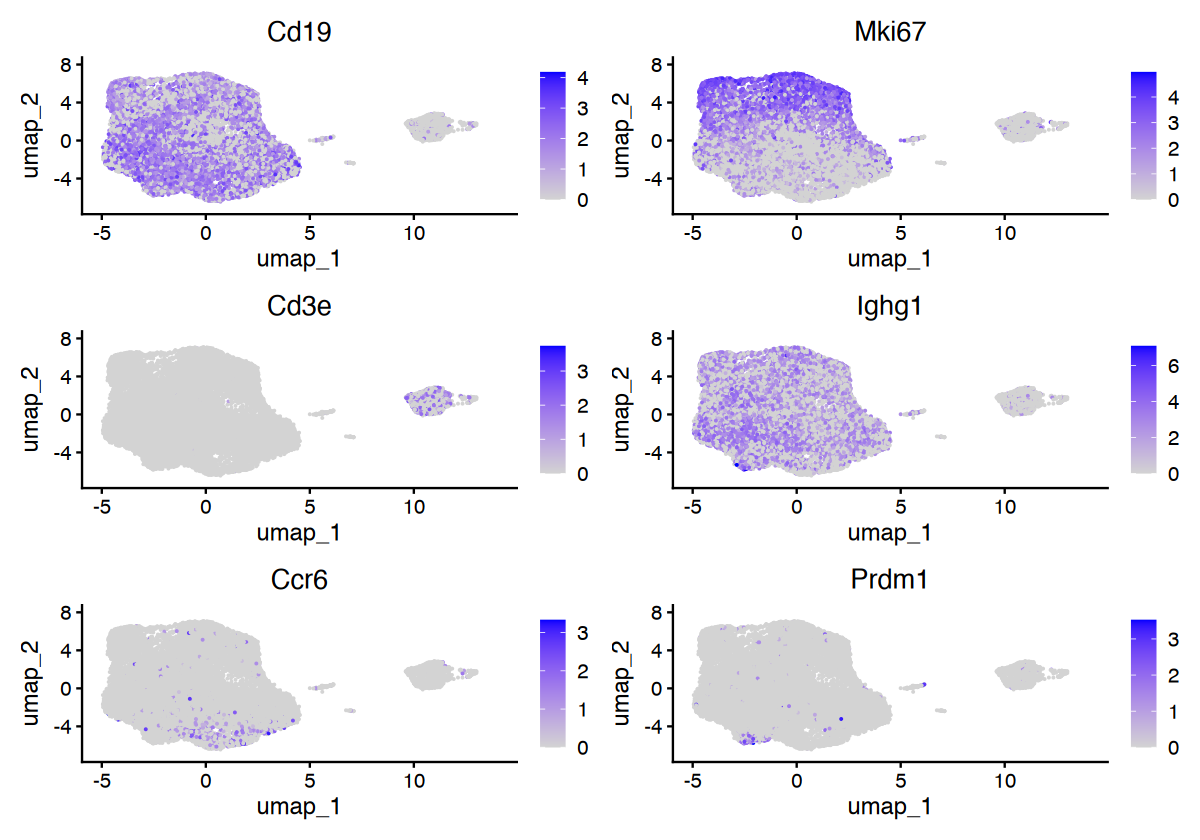

In [30]:
FeaturePlot(srat,c('Cd19','Mki67','Cd3e','Ighg1', 'Ccr6','Prdm1'))

In [27]:
saveRDS(srat,'00_241118Lov_initial_seurat.RDS')

In [3]:
srat = readRDS('00_241118Lov_initial_seurat.RDS')
head(srat@meta.data,1)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.1,RNA_snn_res.0.3,RNA_snn_res.0.5,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
P1_AAAAAATGTCAA,P1,957,382,10.97179,0,0,0,0


In [5]:
write.csv(srat@meta.data,'00_241118Lov_metadata.csv')